In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from scipy.stats import zscore

In [2]:
np.random.seed(42)
# set_backend("cupy")
plt.style.use("default")
sns.set_theme(style="whitegrid")

In [3]:
n_samples_train = 1000
n_samples_test = 100
n_targets = 10000
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
noise_scalar = 0.1

In [4]:
feature_spaces = []
# Generate a random matrix of shape (samples, total rank)
M = np.random.randn(n_samples_train + n_samples_test, sum(d_list))
M = zscore(M)
M

array([[ 0.47184223, -0.12471972,  0.67046674, ...,  0.29841288,
         0.85108902,  0.6857001 ],
       [-0.8779542 , -0.54591604,  0.77395921, ..., -0.99906232,
        -0.42079477,  0.42996468],
       [ 0.73684571, -0.90728224,  0.90104514, ...,  0.13640207,
         1.2493477 , -0.78039671],
       ...,
       [ 1.86417759,  1.13467061, -0.05470728, ..., -0.16307591,
         0.07761028, -0.87354415],
       [ 0.01080282,  0.25354499, -0.05047578, ..., -0.22748839,
        -1.85091248, -1.35096737],
       [ 0.37236962, -0.14983556, -1.36164894, ...,  1.41518184,
        -1.04903332,  0.80812089]], shape=(1100, 300))

<Axes: ylabel='Count'>

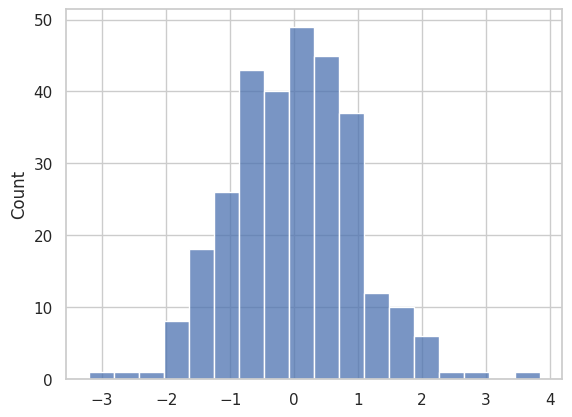

In [5]:
sns.histplot(M[0])

In [6]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)
print(U.shape, S.shape, Vt.shape)
S

(1100, 300) (300,) (300, 300)


array([49.52930877, 49.33874483, 49.04435523, 48.85777223, 48.59780425,
       48.30515054, 48.19762784, 47.74391064, 47.60567271, 47.38248951,
       47.31040164, 47.11333295, 47.05581164, 46.68165859, 46.64153538,
       46.38825538, 46.26812595, 46.17372817, 46.04514253, 45.97483656,
       45.87268864, 45.52702211, 45.46839537, 45.41403153, 45.20645979,
       45.08751567, 44.85957684, 44.80951133, 44.58420962, 44.43933553,
       44.23903519, 44.01973682, 43.98154209, 43.8047093 , 43.72351628,
       43.6650697 , 43.41469849, 43.3676072 , 43.20071775, 43.06050945,
       42.96427738, 42.81398941, 42.70658611, 42.5952928 , 42.49772557,
       42.30831257, 42.1582332 , 42.06899774, 41.85127067, 41.82007078,
       41.6468681 , 41.54589739, 41.45860085, 41.36700383, 41.27945445,
       41.17303134, 41.06842525, 40.83426998, 40.80704864, 40.68091463,
       40.64214108, 40.37243718, 40.35832869, 40.19889136, 40.10231246,
       40.00669827, 39.76371036, 39.70237691, 39.63288849, 39.46

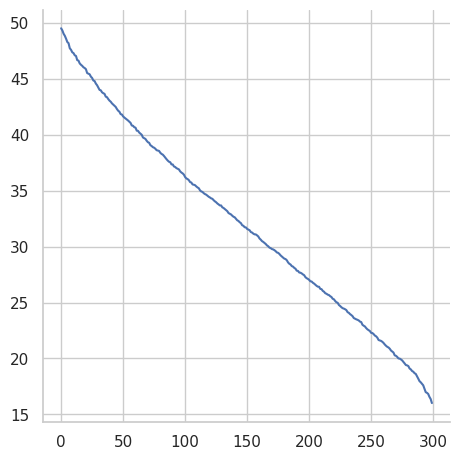

In [7]:
sns.relplot(S, kind="line")

Shuffle U, S and V indices to remove singular value order

In [8]:
index_shuffle = list(range(U.shape[1]))
random.shuffle(index_shuffle)
U = U[:, index_shuffle]
S = S[index_shuffle]
Vt = Vt[index_shuffle, :]

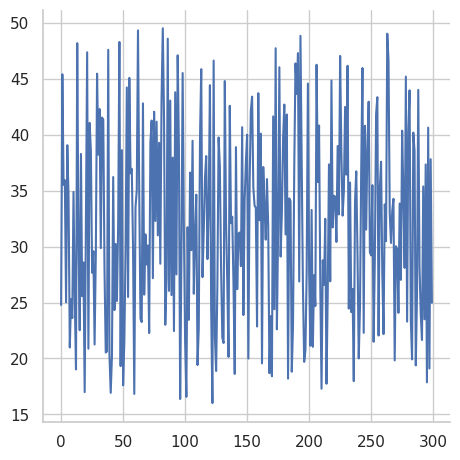

In [9]:
sns.relplot(S, kind="line")

Split up S to create three orthogonal matrices to be used as feature spaces

In [10]:
start = 0
for rank in d_list:
    _S = np.zeros(len(S))
    _S[start:start + rank] = S[start:start + rank]

    diag_S = np.diag(_S)

    space = U @ diag_S @ Vt
    feature_spaces.append(space)
    start += rank
feature_spaces

[array([[ 0.31132933, -0.13380248,  0.07287702, ...,  0.82771414,
          0.23906558, -0.23300935],
        [ 0.38803056, -1.00010278, -0.22693291, ..., -0.21313696,
         -0.26489332,  0.56017338],
        [ 0.52847145,  0.24755843,  0.30857702, ..., -0.09155177,
          0.25550833, -0.28981564],
        ...,
        [ 0.21013892,  0.63203272, -0.2101595 , ...,  0.31164801,
          1.06081557, -0.65003636],
        [-0.10655182,  0.2232829 , -0.01528689, ..., -1.49713314,
         -0.67810769, -0.20382013],
        [ 0.24955134,  0.76094645, -1.23278496, ...,  1.3360571 ,
         -0.18739324, -0.27196813]], shape=(1100, 300)),
 array([[ 0.32023084,  0.23095175,  0.49756962, ..., -0.39139588,
         -0.47720208,  0.60229843],
        [-0.29282609, -0.11514316, -0.14549518, ..., -1.01273955,
         -0.2930412 ,  0.27584034],
        [ 0.32226445, -1.0630568 ,  0.7381102 , ...,  0.49018574,
          0.20786488, -0.0676592 ],
        ...,
        [ 0.03015864,  0.94415133, 

<Axes: ylabel='Count'>

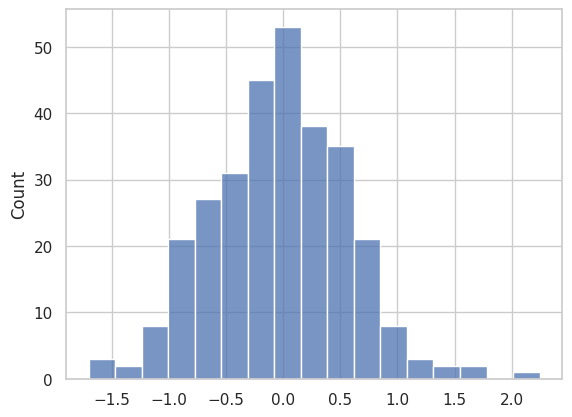

In [11]:
sns.histplot(feature_spaces[0][0])

make sure that all feature spaces are orthogonal to each other (histograms should be nearly 0)

In [12]:
import pandas as pd

matmuls_df = pd.DataFrame()

for i in range(len(feature_spaces)):
    for j in range(i + 1, len(feature_spaces)):
        first_transposed = feature_spaces[i].T @ feature_spaces[j]
        second_transposed = feature_spaces[i] @ feature_spaces[j].T
        matmuls_df = pd.concat([
            matmuls_df,
            pd.DataFrame({'Type': ['First Transposed'], 'Values': [first_transposed[0]]}),
            pd.DataFrame({'Type': ['Second Transposed'], 'Values': [second_transposed[0]]}),
        ], ignore_index=True)

matmuls_df

,Type,Values
0,First Transposed,"[-5.306866057708248e-14, 8.43769498715119e-15, 3.774758283725532e-15, -4.39648317751562e-14, -4.884981308350689e-15, 6.306066779870889e-14, -1.4654943925052066e-13, -3.1530333899354446e-14, -5.639932965095795e-14, -3.019806626980426e-14, 1.554312234475219e-14, -3.175237850427948e-14, 2.7533531010703882e-14, -1.0325074129013956e-14, 3.419486915845482e-14, -5.395683899678261e-14, 4.5075054799781356e-14, 4.8405723873656825e-14, 1.3722356584366935e-13, -3.4638958368304884e-14, 9.769962616701378e-14, 2.0872192862952943e-14, 5.1514348342607263e-14, 3.108624468950438e-14, -3.552713678800501e-14, -3.552713678800501e-15, -7.016609515630989e-14, -3.197442310920451e-14, 8.881784197001252e-15, 3.9968028886505635e-15, -4.707345624410664e-14, 1.3766765505351941e-14, -7.105427357601002e-15, -3.186340080674199e-14, 5.0182080713057076e-14, 1.7763568394002505e-14, 5.129230373768223e-14, -4.884981308350689e-15, 1.3322676295501878e-15, -4.4853010194856324e-14, 1.9539925233402755e-14, 2.5451862839531714e-14, -3.597122599785507e-14, 4.085620730620576e-14, -1.2434497875801753e-14, 1.5987211554602254e-14, -4.440892098500626e-15, -5.3734794391857577e-14, 8.881784197001252e-15, 1.5987211554602254e-14, -8.304468224196171e-14, 8.348877145181177e-14, -3.241851231905457e-14, -9.070522111187529e-14, 2.731148640577885e-14, -1.1812772982011666e-13, -1.0347278589506459e-13, 1.212363542890671e-13, 3.68594044175552e-14, -1.9984014443252818e-14, -2.8199664825478976e-14, 7.394085344003543e-14, 3.108624468950438e-14, 4.163336342344337e-15, 4.529709940470639e-14, -5.728750807065808e-14, -1.1102230246251565e-14, -4.9960036108132044e-14, 0.0, 3.9968028886505635e-14, -1.0658141036401503e-14, 7.993605777301127e-15, -1.865174681370263e-14, 9.636735853746359e-14, -7.283063041541027e-14, 3.9968028886505635e-14, -1.1546319456101628e-14, 4.796163466380676e-14, -3.552713678800501e-14, -5.329070518200751e-15, -2.0317081350640365e-14, -4.440892098500626e-15, 6.661338147750939e-14, -2.0872192862952943e-14, -4.063416270128073e-14, 3.952393967665557e-14, 7.72715225139109e-14, 5.773159728050814e-15, -5.329070518200751e-15, -6.572520305780927e-14, -3.83026943495679e-14, 5.3734794391857577e-14, 1.199040866595169e-14, -1.687538997430238e-14, -2.9032332093947844e-14, -7.327471962526033e-15, -3.860106678743591e-14, 4.3520742565306136e-14, -4.529709940470639e-14, 4.1723569044194164e-14, ...]"
1,Second Transposed,"[5.329070518200751e-15, -3.1086244689504383e-15, -7.549516567451064e-15, -1.509903313490213e-14, 8.881784197001252e-15, -1.509903313490213e-14, 9.547918011776346e-15, -1.0769163338864018e-14, 5.329070518200751e-15, 8.881784197001252e-15, -8.881784197001252e-15, 2.0095036745715333e-14, 3.1086244689504383e-15, 9.2148511043888e-15, 3.552713678800501e-15, -1.1324274851176597e-14, -2.220446049250313e-14, 3.9968028886505635e-15, -8.243405957841787e-15, -1.4654943925052066e-14, -1.0880185641326534e-14, 2.930988785010413e-14, -7.993605777301127e-15, -3.552713678800501e-15, -1.4210854715202004e-14, 0.0, 8.659739592076221e-15, -2.220446049250313e-16, -2.708944180085382e-14, -1.9984014443252818e-14, -7.327471962526033e-15, 1.7319479184152442e-14, 3.1086244689504383e-15, -1.865174681370263e-14, -1.3766765505351941e-14, 3.1086244689504383e-15, 4.440892098500626e-15, 1.4210854715202004e-14, 1.326716514427062e-14, 1.354472090042691e-14, 1.021405182655144e-14, -7.549516567451064e-15, -1.9317880628477724e-14, 4.440892098500626e-15, 1.4210854715202004e-14, -8.881784197001252e-16, -5.0182080713057076e-14, -1.3322676295501878e-15, 3.9968028886505635e-15, 6.217248937900877e-15, -3.885780586188048e-15, 7.993605777301127e-15, 7.549516567451064e-15, -2.220446049250313e-16, 8.881784197001252e-15, 1.865174681370263e-14, -9.325873406851315e-15, 7.105427357601002e-15, -1.687538997430238e-14, 8.43769498715119e-15, -1.687538997430238e-14, 8.881784197001252e-16, 1.4210854715202004e-14, -1.5543122344752192e-15, 2.6645352591003757e-15, -8.881784197001252e-15, -1.3322676295501878

Text(528.1979166666667, 0.5, 'Frequency')

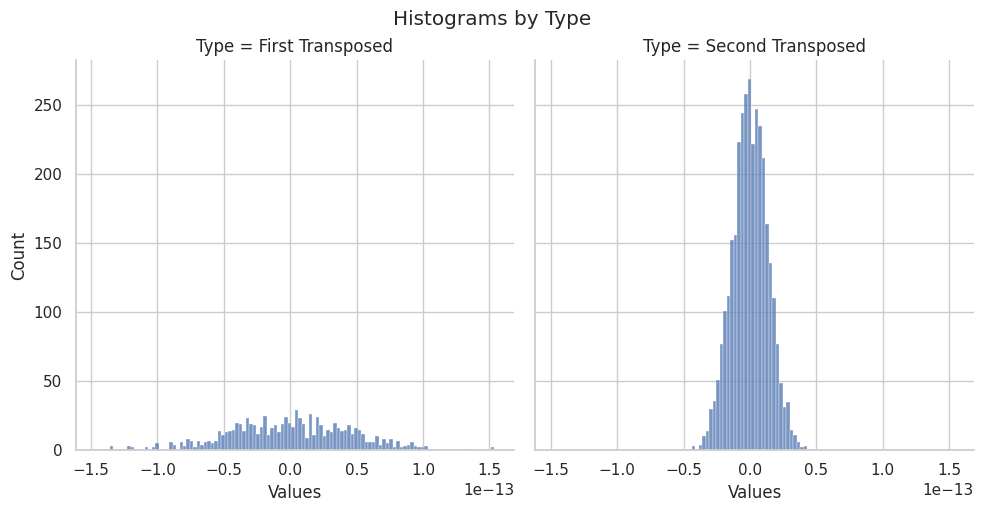

In [13]:
# Flatten the arrays in the 'Values' column
matmuls_df["Values"] = matmuls_df["Values"].apply(lambda x: x.flatten() if isinstance(x, np.ndarray) else x)

# Plot the distribution using seaborn
sns.displot(data=matmuls_df.explode("Values"), x="Values", multiple="stack", col="Type")
plt.suptitle('Histograms by Type', y=1.02)
plt.xlabel('Values')
plt.ylabel('Frequency')

split feature spaces into train and test samples

In [14]:
feature_spaces_train = [feature_space[:n_samples_train] for feature_space in feature_spaces]
feature_spaces_test = [feature_space[n_samples_train:] for feature_space in feature_spaces]

add the first feature with all other feature spaces
[0 + 1, 0 + 2, 0 + 3, ...]

In [15]:
Xs_train = [1 / 2 * (feature_spaces_train[0] + feature_space) for feature_space in feature_spaces_train[1:]]
Xs_test = [1 / 2 * (feature_spaces_test[0] + feature_space) for feature_space in feature_spaces_test[1:]]

Xs_train = [zscore(x) for x in Xs_train]
Xs_test = [zscore(x) for x in Xs_test]

generate weights

In [16]:
betas = [np.random.randn(sum(d_list), n_targets) for _ in d_list]
betas = [zscore(beta) for beta in betas]
betas

[array([[-0.38460629, -0.16970626, -0.43662699, ...,  0.76389093,
         -0.54724117,  2.90284843],
        [-0.09814713, -0.20278397,  0.5237513 , ...,  0.93230933,
          1.28752009,  0.04879971],
        [ 0.47496226, -0.72079155, -0.59932401, ..., -0.25245321,
         -0.37423414, -0.61704289],
        ...,
        [ 1.39478625,  0.53454755,  0.11210573, ...,  0.33811356,
          0.07469666,  0.29992802],
        [-0.61751344,  0.74781886,  0.45996191, ...,  2.27891114,
          0.04883194,  0.07789179],
        [-0.98042467, -0.2961056 , -0.67027179, ..., -0.92429298,
          0.47219762,  0.44713567]], shape=(300, 10000)),
 array([[-1.40169847,  2.67279918,  2.03973585, ..., -0.03094923,
         -0.58427223, -0.49388827],
        [-0.66347222,  1.0093984 ,  0.65018904, ..., -0.88144256,
         -1.113028  ,  0.78376731],
        [-1.5680825 , -0.47965058,  1.07959107, ..., -1.27468081,
         -0.45572124,  0.11798338],
        ...,
        [ 1.07480511, -1.37367909,

create targets

In [17]:
Y_train = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_train, betas)])
Y_test = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_test, betas)])
Y_train = zscore(Y_train)
Y_test = zscore(Y_test)

add noise

In [18]:
noise_train = zscore(np.random.randn(n_samples_train, n_targets))
noise_test = zscore(np.random.randn(n_samples_test, n_targets))
Y_train += noise_train * noise_scalar
Y_test += noise_test * noise_scalar
noise_train * noise_scalar

array([[-0.00063417,  0.01154315, -0.03187855, ...,  0.08611207,
        -0.12916102,  0.08738936],
       [ 0.03938965,  0.00242483, -0.02673386, ...,  0.11971031,
        -0.16322497,  0.09760446],
       [ 0.08482156, -0.09030948,  0.05056161, ..., -0.02505592,
         0.01699247, -0.00441444],
       ...,
       [ 0.15958723,  0.01918551,  0.11944391, ..., -0.06331546,
        -0.02140708,  0.12214556],
       [-0.03527165,  0.07056346, -0.27609341, ...,  0.1827738 ,
         0.00448845, -0.07623852],
       [ 0.19636524,  0.04896127,  0.02460273, ...,  0.02527466,
         0.09929174, -0.21056221]], shape=(1000, 10000))

train simple linear models to confirm feature spaces predict the target

In [21]:
scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(feature_spaces_train))]
for i, model in enumerate(linear_models):
    model.fit(feature_spaces_train[i], Y_train)
    score = model.score(feature_spaces_test[i], Y_test)
    scores = pd.concat([
        scores,
        pd.DataFrame({'model': [i], 'Type': ['Score'], 'Values': [score.mean()]})], ignore_index=True
    )

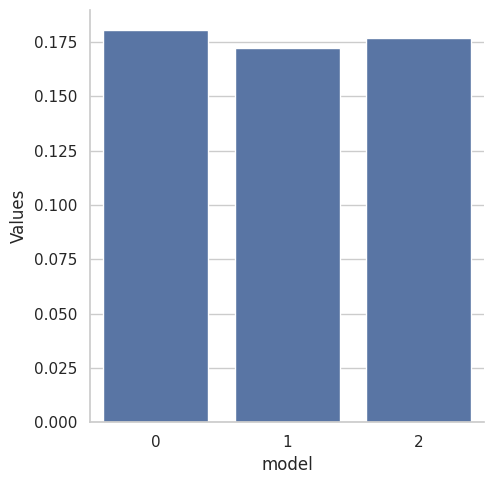

In [22]:
sns.catplot(scores, x="model", y="Values", kind="bar")

now train on researcher side feature spaces

In [23]:
researcher_scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(Xs_train))]
for i, model in enumerate(linear_models):
    model.fit(Xs_train[i], Y_train)
    score = model.score(Xs_test[i], Y_test)
    researcher_scores = pd.concat([
        researcher_scores,
        pd.DataFrame({'model': [i], 'Type': ['Score'], 'Values': [score.mean()]})], ignore_index=True
    )

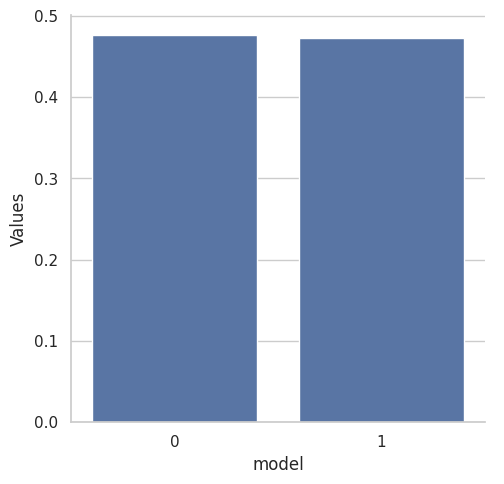

In [24]:
sns.catplot(researcher_scores, x="model", y="Values", kind="bar")